## Create and test ion channel model

In [1]:
from experiments.ikr_markov import (toyoda_iv,
                                    toyoda_taua,
                                    toyoda_deact,
                                    toyoda_trec,
                                    toyoda_inact)

In [2]:
from ionchannelABC.experiment import setup
from ionchannelABC import plot_sim_results

In [3]:
modelfile = 'models/ikr_markov.mmt'
#modelfile = 'models/Korhonen2009_iKr.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                toyoda_iv,
                                                toyoda_taua,
                                                toyoda_deact,
                                                toyoda_trec,
                                                toyoda_inact)

In [5]:
assert len(observations)==len(summary_statistics(model({})))

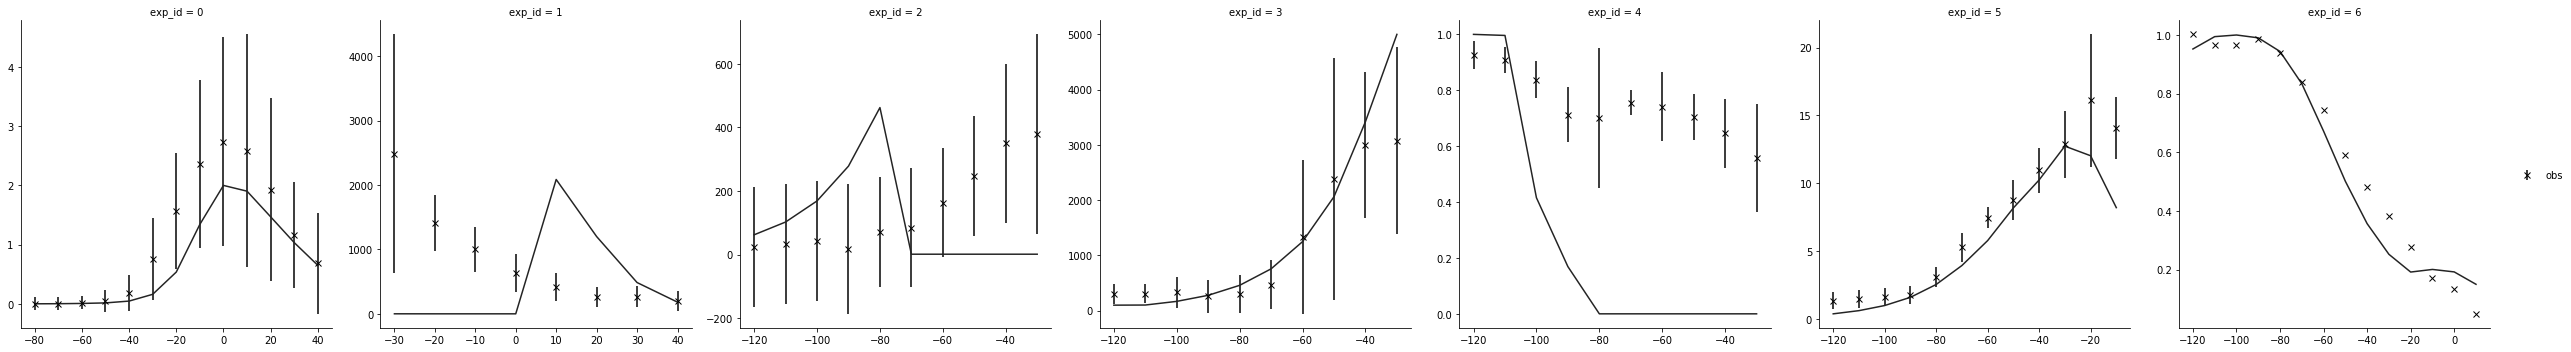

In [6]:
g = plot_sim_results(modelfile, toyoda_iv, toyoda_taua, toyoda_deact, toyoda_trec, toyoda_inact)

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {'log_ikr.p_1': (-7., 3.),
          'ikr.p_2': (1e-7, 0.4),
          'log_ikr.p_3': (-7., 3.),
          'ikr.p_4': (1e-7, 0.4),
          'log_ikr.p_5': (-7., 3.),
          'ikr.p_6': (1e-7, 0.4),
          #'log_ikr.p_7': (-7., 3.),
          #'ikr.p_8': (1e-7, 0.4),
          'log_ikr.p_9': (-7., 3.),
          'ikr.p_10': (1e-7, 0.4),
          'log_ikr.p_11': (-7., 3.),
          'ikr.p_12': (1e-7, 0.4),
          'ikr.s_A': (0., 1.),
          'ikr.h_A': (-50., 50.),
          'ikr.g_Kr': (0., 10.)
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ikr.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ikr.db


In [9]:
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [10]:
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 8192 particles


In [11]:
from pyabc import ABCSMC
from pyabc.populationstrategy import ConstantPopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=4),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.597186390962737, '1': 1.597186390962737, '2': 1.597186390962737, '3': 1.199447754040103, '4': 0.7055575023765238, '5': 0.31565366089199126, '6': 0.22211995445186905, '7': 0.15377761139573856, '8': 0.12365440763299941, '9': 0.11105879930816166, '10': 0.14111150047530527, '11': 0.24478525592655018, '12': 0.2552078696751163, '13': 0.1745824888726518, '14': 0.7357404888204586, '15': 0.9363969857714968, '16': 1.084249141419631, '17': 1.4714809776409172, '18': 2.0600733686972874, '19': 2.0600733686972874, '20': 2.0600733686972874, '21': 0.20947738701575155, '22': 0.20947738701574936, '23': 0.20947738701575155, '24': 0.19342732743841867, '25': 0.2285207858353649, '26': 0.20947738701575155, '27': 0.22860960075407533, '28': 0.20947738701575155, '29': 0.1571080402618145, '30': 0.12568643220945042, '31': 1.8513870519545848, '32': 1.8521063165435752, '33': 1.1321115314136982, '34': 1.0720309554268252, '35': 0.9258733072019967, '36': 0.7276131957849679, '37': 

In [12]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [13]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0


In [32]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
     parameter_priors=prior,
     distance_function=IonChannelDistance(
         exp_id=list(observations.exp_id),
         variance=list(observations.variance),
         delta=0.05),
     population_size=ConstantPopulationSize(5000),
     summary_statistics=summary_statistics,
     transitions=EfficientMultivariateNormalTransition(),
     eps=MedianEpsilon(),
     sampler=MulticoreEvalParallelSampler(n_procs=12),
     acceptor=IonChannelAcceptor())

In [33]:
abc_continued.load(db_path, 1)

1

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.001)

INFO:Epsilon:initial epsilon is 1.0425899846808604
INFO:ABC:t:32 eps:1.0425899846808604


# Results analysis

In [7]:
from pyabc import History

In [8]:
db_path = 'sqlite:////scratch/cph211/tmp/hl1_ikr.db'

In [9]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-07-21 10:49:19.500458, end_time=2019-08-01 06:13:52.383080)>]

In [10]:
history.id = 1

In [11]:
df, w = history.get_distribution(m=0)

In [12]:
df.describe()

name,ikr.g_Kr,ikr.h_A,ikr.p_10,ikr.p_12,ikr.p_2,ikr.p_4,ikr.p_6,ikr.s_A,log_ikr.p_1,log_ikr.p_11,log_ikr.p_3,log_ikr.p_5,log_ikr.p_9
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.080325,-44.615631,0.174112,0.036925,0.161077,4.016003e-03,0.210882,2.543383,-3.906604,-1.842225,-2.113006,-1.940137,-1.312220
std,0.522065,30.932091,0.091993,0.004000,0.095212,5.149288e-03,0.106415,1.323315,0.857808,0.109679,0.155478,2.639524,0.853701
min,0.000493,-99.999053,0.013678,0.023509,0.027561,4.308296e-07,0.000291,0.001537,-6.863786,-2.401141,-3.261654,-6.996931,-4.894557
25%,0.660185,-69.749140,0.100346,0.034152,0.071437,1.305734e-03,0.123790,1.487441,-4.500833,-1.906042,-2.137954,-4.093315,-1.686823
50%,1.109740,-46.020750,0.155440,0.036667,0.143863,2.611475e-03,0.214230,2.582838,-3.887027,-1.832550,-2.075089,-1.929435,-1.193249
75%,1.511396,-20.468184,0.237489,0.039405,0.235238,4.857688e-03,0.300355,3.599152,-3.276156,-1.766524,-2.032401,0.256533,-0.769338
max,1.999839,58.600109,0.399833,0.057456,0.399806,4.197159e-02,0.399968,4.999725,-0.699004,-1.495051,-1.968922,2.999313,0.664363


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


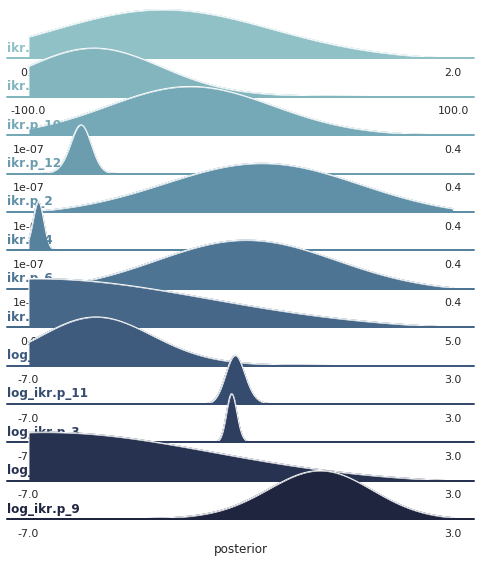

In [13]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [14]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [15]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

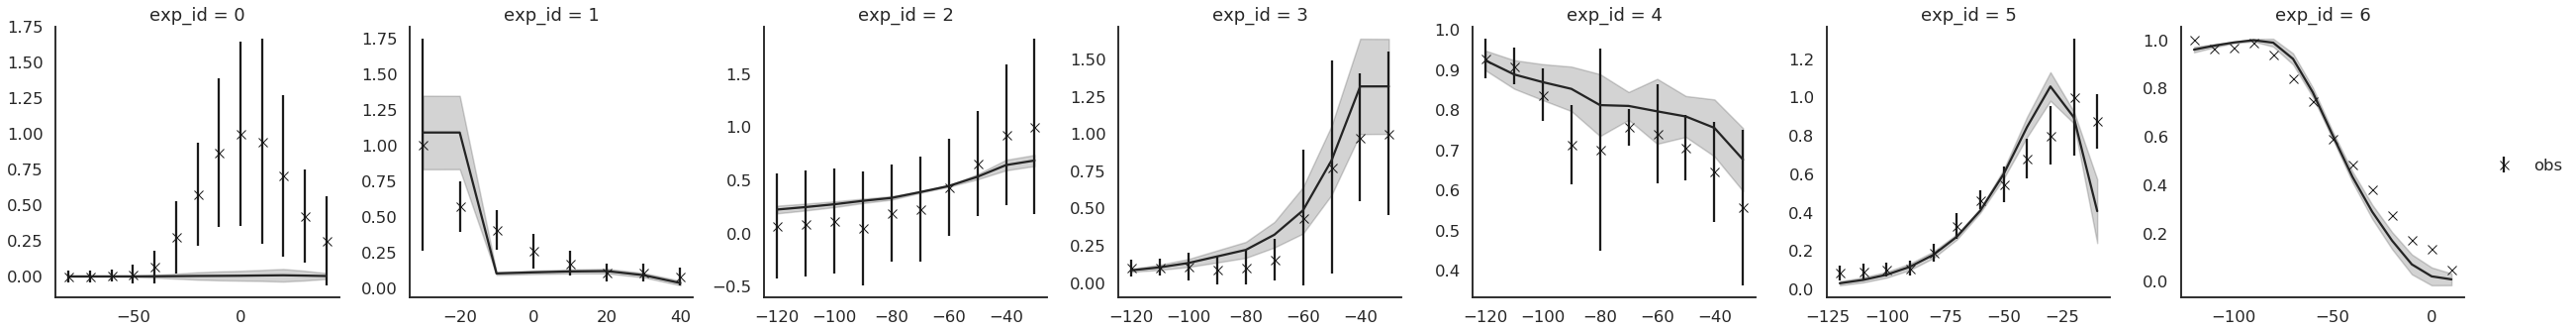

In [16]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [19]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp_id',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

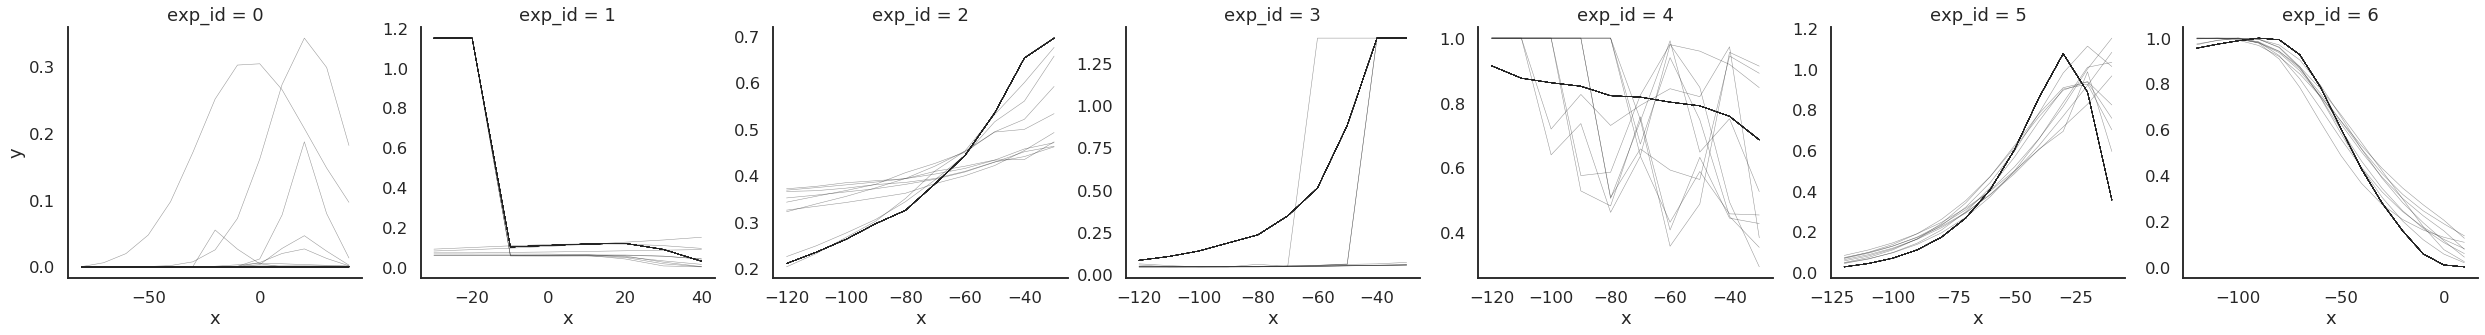

In [20]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
